## import Modules 

In [1]:
!pip install pydot
!pip install graphviz

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [6]:
BASE_DIR = 'C:/Users/hp/Flicker8k'
WORKING_DIR = 'C:/Users/hp/AppData/Local/Programs/Python/working'

In [4]:
if not os.path.exists(BASE_DIR):
  os.makedirs(BASE_DIR)

if not os.path.exists(WORKING_DIR):
  os.makedirs(WORKING_DIR)

## Extract image Features

In [5]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 145s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [14]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixel to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for VGG
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image Id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [40]:
# store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR, 'features.pkl'),'wb'))

In [27]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'),'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [8]:
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt'),'r') as f:
    captions_doc = f.read()

In [10]:
captions_doc

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [34]:
# create mapping of images to caption
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    line = line.replace('#0\t', ',').replace('#1\t', ',').replace('#2\t', ',').replace('#3\t', ',').replace('#4\t', ',')
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension form image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [35]:
del mapping['2258277193_586949ec62']

In [7]:
len(mapping)

8091

## Preprocess text data

In [36]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits,special chars etc.
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            #add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [37]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [38]:
#preprocess the text
clean(mapping)

In [39]:
# after preprocess the text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [40]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [41]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [42]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

8483

In [43]:
# get maximum length of the caption available
max_length = max(len(caption.split())for caption in all_captions)
max_length

34

## Train test split

In [44]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [45]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images 
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each captions
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X,Y pairs 
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y = np.array(X1), np.array(X2), np.array(y)
                yield [X1,X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

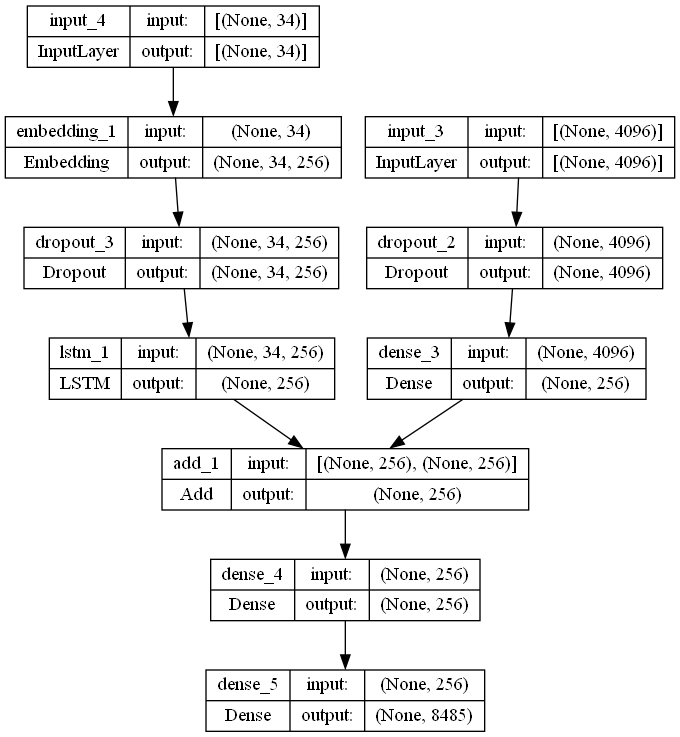

In [46]:
#encoder model
#image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
#sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
 
model = Model(inputs = [inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot the model
plot_model(model, show_shapes= True)

In [47]:
# train the model
epochs = 30
batch_size = 64
steps = len(train)//batch_size
for i in range(epochs):
    #create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose=1)

113/113 [==============================] - 440s 4s/step - loss: 2.0573


In [20]:
'2258277193_586949ec62' in mapping.keys()

False

In [48]:
#save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate captions for image

In [49]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [50]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequences
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

## BLEU Score

In [51]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the captions for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU Score
smooth = SmoothingFunction().method4
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533304
BLEU-2: 0.310647


## Visualize the results

In [52]:
from PIL import Image
import matplotlib.pyplot as plt 
def generate_caption(image_name): 
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Flicker8k_Dataset", image_name)
    image = Image.open(img_path) 
    captions = mapping[image_id]
    print('--------------------------Actual---------------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------------Predicted---------------------------')
    print(y_pred)
    plt.imshow(image)

--------------------------Actual---------------------------
startseq girl in pool wearing goggles and surrounded by other children endseq
startseq girl in green goggles in pool with three other children endseq
startseq red haired girl making peace sign is wearing neon green glasses and floaties and playing in the pool with other kids endseq
startseq red-headed girl offers the peace sign as she swims in the pool with floaties endseq
startseq young girl with goggles and floaties poses for the camera as she plays in pool endseq
--------------------------Predicted---------------------------
startseq five young boys in swimming pool endseq


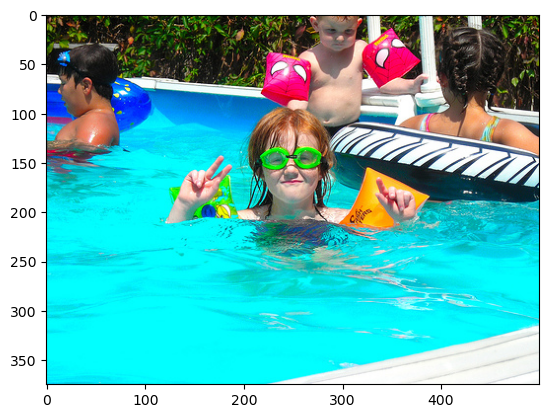

In [54]:
generate_caption("989754491_7e53fb4586.jpg")

--------------------------Actual---------------------------
startseq climber is sillhouetted against the sky and rocks as he hangs by rope from another rock endseq
startseq person hangs from safety rope as he climbs down large cliff endseq
startseq person is abseiling down rock face attached to rope endseq
startseq person jumping down rope on cliff endseq
startseq the man repels down the side of cliff endseq
--------------------------Predicted---------------------------
startseq man rock climbing endseq


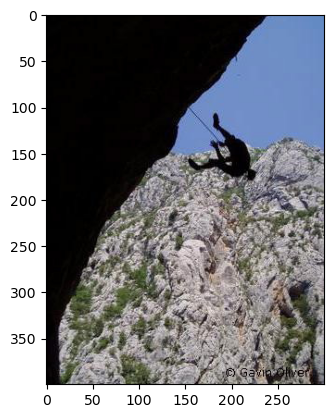

In [55]:
generate_caption('883040210_3c4a10f030.jpg')

--------------------------Actual---------------------------
startseq boy is upside down in midair near lake at sunset endseq
startseq person does flip by two sailboats and lake endseq
startseq person flipping upside down endseq
startseq person in midair doing back flip endseq
startseq person is doing flip in midair near lake with sails behind him endseq
--------------------------Predicted---------------------------
startseq man in black shirt is jumping over another mans back endseq


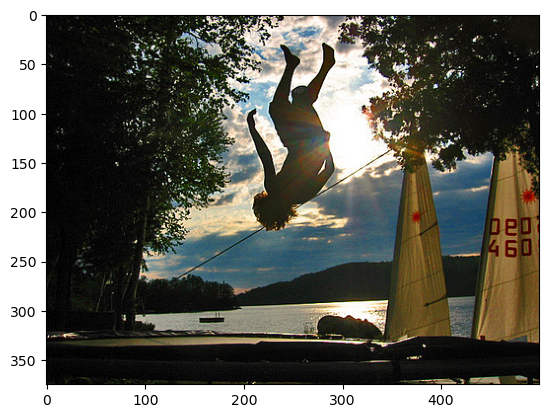

In [56]:
generate_caption('888425986_e4b6c12324.jpg')